## Exercise: Maximizing flow in a network

<font color='blue'><b>Goal:</b></font>
Solve a max-flow problem.

<font color='blue'><b>Additional resources:</b></font> 
More on flows will be covered later in the lecture, but this problem does not require any prior knowledge of flows.

---

A company wants to drive goods from Spain (S) to Austria (A).
The company can drive through France (F), Germany (G), and Switzerland (C).

Run the following lines of code to visualize this network. You do not need to know what this code means.

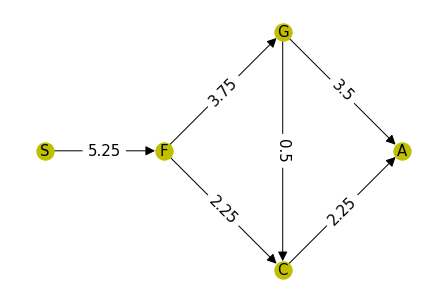

In [28]:
# Import Python tools to draw a network
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Create the graph
G=nx.DiGraph()
G.add_nodes_from(["F","G","C","S","A"])
vertex_pos = {"F": (0, .5),"G": (1, 1),"C": (1, 0),"S": (-1, 0.5),"A": (2, .5)}
G.add_edges_from([("S","F"),("G","A"),("C","A"),("F","G"),("F","C"),("G","C")])

# Display the capacities
nx.draw(G,vertex_pos,with_labels=True,font_size=15, arrowsize = 20, node_color = 'y')

# Add edge capacities
capacities=dict({("S","F"): 5.25,("C","A"): 2.25,("G","A") :3.5,("F","G"): 3.75,("F","C"): 2.25,("G","C"): .5})
nx.draw_networkx_edge_labels(G,pos=vertex_pos,label_pos=0.5, edge_labels=capacities,font_size=15)

plt.show()

Each road in the network has two components: a direction and a capacity. 
For example, the road from Spain to France has a capacity of 5.25 units.
This means that the company cannot ship more than 5.25 units of goods between Spain and France.

The company needs to find a feasible way of transporting goods from Spain to Austria. 
A <font color="blue">feasible flow</b></font> assigns an amount of flow to each road in the network such that the following holds:

<b>(Capacity constraints)</b> - No road is assigned more than its capacity, and

<b>(Conservation constraints)</b> - There can be no leftover flow in France, Germany, or Switzerland. Therefore, the amount of flow into France (similarly, the amount of flow into Germany or Switzerland) must equal the amount of flow out of France (similarly, the amount of flow out of Germany or Switzerland).

Here are three example of flows (both feasible and infeasible). 
For each pair of countries $x,y \in \{S,F,G,C,A\}$ with a road between them, let $f_{x,y}$ be the amount of flow assigned to that road.

Example 1. $f_{S,F} = 2, f_{F,G} = 1,f_{F,C} = 1,f_{G,C} = 0,f_{G,A} = 1,f_{C,A} = 1$ is a feasible flow.

Example 2. $f_{S,F} = 2, f_{F,G} = 2,f_{F,C} = 2,f_{G,C} = 0,f_{G,A} = 2,f_{C,A} = 2$ is infeasible because France has two incoming units but four outgoing units. This violates the conservation constraints.

Example 3. $f_{S,F} = 3, f_{F,G} = 2,f_{F,C} = 1,f_{G,C} = 1,f_{G,A} = 1,f_{C,A} = 1$ is infeasible because $f_{G,C} > 0.5$. This violates the capacity constraints. 

The <font color="blue">value of a feasible flow</b></font> is the value of flow entering Austria, i.e., the value $f_{C,A}+f_{G,A}$.

<font color="blue"><b>Your task:</b></font> Write a linear program to find a flow of maximum value from Spain to Austria. To this end, introduce a variable for each flow value (as above), and try to formulate the capacity constraints as well as the flow conservation constraints as linear inequalities. Also, come up with a linear objective function such that maximizing it corresponds to maximizing the value of the flow given by the variables.<br>
Finally, implement the LP, solve it, and check what the flow of maximum value is (i.e., say how much flow there is on every road of the network).

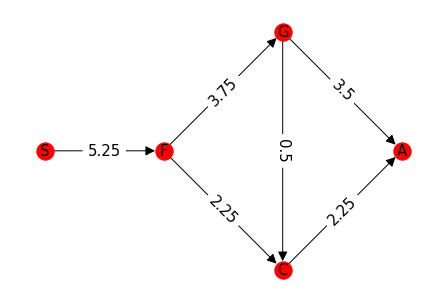

In [34]:
nx.draw(G, vertex_pos, with_labels=True, font_size=15, arrowsize=20, node_color='r')
edge_draw = nx.draw_networkx_edge_labels(G, pos=vertex_pos, label_pos=0.5, edge_labels=capacities, font_size=15)

In [30]:
for e in G.edges:
    G.edges[e]['capacity'] = capacities[e]

total_flow, edge_flow = nx.maximum_flow(G, 'S', 'A', capacity='capacity')

In [31]:
print(f'The maximum flow from Spain to Austria is {total_flow:.2f}')

The maximum flow from Spain to Austria is 5.25


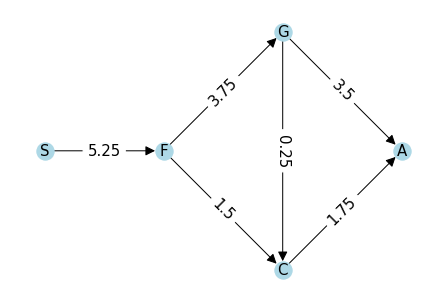

In [32]:
for e in G.edges:
    G.edges[e]['flow'] = edge_flow[e[0]][e[1]]

nx.draw(G, vertex_pos, with_labels=True, font_size=15, arrowsize=20, node_color='lightblue')
edge_draw = nx.draw_networkx_edge_labels(G, pos=vertex_pos, label_pos=0.5, edge_labels=nx.get_edge_attributes(G, 'flow'), font_size=15)

# Mathematical Model

As stated above, we use a variable $f_{x,y}$ to denote the amount of goods assigned to the road from country $x$ to country $y$, where $x,y \in \{S,F,G,C,A\}$. Let $c_{x,y}$ be the capacity of the road between country $x$ and country $y$. The objective is to maximize the amont of goods transported from Spain to Austria.

Therefore, we are able to draw a mathematical model of the problem.

<b>Variables</b>
$$
\begin{array}{rcl}
    f_{S,F} & f_{F,G} & f_{F,C} & f_{G,A} & f_{G,C} & f_{C,A}\\
\end{array}
$$

<b>Objective</b>
$$
\begin{array}{rcl}
    \max & f_{S,F}\\
\end{array}
$$

<b>Capacity constraints</b>
$$
\begin{array}{rcl}
    & f_{x,y} \leq c_{x,y} & x,y \in (S,F), (F,G), (F,C), (G,A), (G,C), (C,A)\\
\end{array}
$$

<b>Conservation constraints</b>
$$
\begin{array}{rcl}
    & f_{S,F}-f_{F,G}-f_{F,C}=0\\
    & f_{F,G}-f_{G,A}-f_{G,C}=0\\
    & f_{F,C}+f_{G,C}-f_{C,A}=0\\
\end{array}
$$

In [52]:
from pulp import *

MaxFlow_LP = LpProblem("Spain_to_Austria", LpMaximize)
Countries = ['S', 'F', 'G', 'C', 'A']
Arcs = [('S', 'F'), ('F', 'G'), ('F', 'C'), ('G', 'A'), ('G', 'C'), ('C', 'A')]

# f_{S,F}, f_{F,G}, f_{F,C}, f_{G,A}, f_{G,C}, f_{C,A} 
edge_cap = [5.25, 3.75, 2.25, 3.5, 0.5, 2.25]

In [53]:
variables = [LpVariable(f'f{arc[0]}{arc[1]}', lowBound=0) for arc in Arcs]

In [54]:
MaxFlow_LP += variables[0]

In [55]:
MaxFlow_LP += variables[0] - variables[1] - variables[2] == 0
MaxFlow_LP += variables[1] - variables[3] - variables[4] == 0
MaxFlow_LP += variables[2] + variables[4] - variables[5] == 0
for i in range(len(Arcs)):
    MaxFlow_LP += variables[i] <= edge_cap[i]


In [56]:
print(MaxFlow_LP)

Spain_to_Austria:
MAXIMIZE
1*fSF + 0
SUBJECT TO
_C1: - fFC - fFG + fSF = 0

_C2: fFG - fGA - fGC = 0

_C3: - fCA + fFC + fGC = 0

_C4: fSF <= 5.25

_C5: fFG <= 3.75

_C6: fFC <= 2.25

_C7: fGA <= 3.5

_C8: fGC <= 0.5

_C9: fCA <= 2.25

VARIABLES
fCA Continuous
fFC Continuous
fFG Continuous
fGA Continuous
fGC Continuous
fSF Continuous



In [57]:
MaxFlow_LP.solve()

1

In [63]:
for i in range(len(Arcs)):
    print(f'The amount of goods transported from {Arcs[i][0]} to {Arcs[i][1]} is {variables[i].value():.2f}')

opt_val = value(MaxFlow_LP.objective)
print(f'The maximal amount of goods is {opt_val:.2f}')

The amount of goods transported from S to F is 5.25
The amount of goods transported from F to G is 3.00
The amount of goods transported from F to C is 2.25
The amount of goods transported from G to A is 3.00
The amount of goods transported from G to C is 0.00
The amount of goods transported from C to A is 2.25
The maximal amount of goods is 5.25


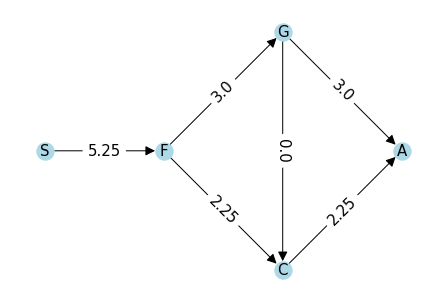

In [67]:
for e in G.edges:
    G.edges[e]['flow'] = variables[Arcs.index(e)].value()
nx.draw(G, vertex_pos, with_labels=True, font_size=15, arrowsize=20, node_color='lightblue')
edge_draw = nx.draw_networkx_edge_labels(G, pos=vertex_pos, label_pos=0.5, edge_labels=nx.get_edge_attributes(G, 'flow'), font_size=15)